<a href="https://colab.research.google.com/github/kodikarthik21/CS6910---Fundamentals-of-Deep-Learning/blob/main/Assignment02/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
!pip install wandb

In [28]:
import wandb
wandb.login()

wandb: Currently logged in as: kodikarthik21 (use `wandb login --relogin` to force relogin)


True

In [11]:
!unzip '/content/drive/MyDrive/nature_12K'

Streaming output truncated to the last 5000 lines.
  inflating: inaturalist_12K/train/Arachnida/1ac25349af662e85f577a31f64beca41.jpg  
  inflating: inaturalist_12K/train/Arachnida/117ef7f1812725f359500448a258e713.jpg  
  inflating: inaturalist_12K/train/Arachnida/6409254954c3b46d88d64f0bf4c632fa.jpg  
  inflating: inaturalist_12K/train/Arachnida/aaed865750bd52944658a7dd23366948.jpg  
  inflating: inaturalist_12K/train/Arachnida/460cc09ef510d400a4d47a836ddd45e6.jpg  
  inflating: inaturalist_12K/train/Arachnida/55c48c3afef0b745e53951284cdb2db4.jpg  
  inflating: inaturalist_12K/train/Arachnida/bff3daa961ee96a37ebe12dc0bcce504.jpg  
  inflating: inaturalist_12K/train/Arachnida/9082d4f2107bccf1f14d71c8944be607.jpg  
  inflating: inaturalist_12K/train/Arachnida/93d0130423d42f7c6228150eb95a2a93.jpg  
  inflating: inaturalist_12K/train/Arachnida/051aba6d7bc324bad76bd438ed3cc276.jpg  
  inflating: inaturalist_12K/train/Arachnida/67595af09c015c7753d5d4935677590f.jpg  
  inflating: inaturalist_

#Question 1 (5 Marks)



Build a small CNN model consisting of  5 convolution layers. Each convolution layer would be followed by a ReLU activation and a max pooling layer. Here is sample code for building one such conv-relu-maxpool block in keras. 

After 5 such conv-relu-maxpool blocks of  layers you should have one dense layer followed by the output layer containing 10 neurons (1 for each of the 10 classes). The input layer should be compatible with the images in the iNaturalist dataset.






In [29]:
import numpy as np
import tensorflow as tf 
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from keras import backend as K
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
from numpy.random import seed
from numpy.random import randint
tf.test.gpu_device_name()

'/device:GPU:0'

In [30]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory('/content/inaturalist_12K/train',labels = 'inferred', 
                                                                    validation_split=0.1, seed = 123, subset = "training")

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory('/content/inaturalist_12K/train', labels = 'inferred',
                                                                    validation_split=0.1, seed = 123, subset = "validation")

test_dataset = tf.keras.preprocessing.image_dataset_from_directory('/content/inaturalist_12K/val', labels = 'inferred',seed = 123)


Found 9999 files belonging to 10 classes.
Using 9000 files for training.
Found 9999 files belonging to 10 classes.
Using 999 files for validation.
Found 2000 files belonging to 10 classes.


In [85]:
print(train_dataset)

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>


In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
class_names = train_dataset.class_names
for images, labels in train_dataset.take(1):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

KeyboardInterrupt: ignored

<Figure size 720x720 with 0 Axes>

In [31]:
def model_framework(): 
#---------DEFAULT HYPERPARAMETERS-----------------------------------------------
  hyperparameter_defaults = dict(
        max_epoch = 10,
        num_filters = 128,
        filter_org = 'double',
        data_augmentation = 'N',
        dropout = 0.4,
        batch_normalization = 'Y',
        optimizer = 'nag'
      )
  
#----------------SETTING UP WANDB-----------------------------------------------
  wandb.init(project="Assignment 2", config=hyperparameter_defaults)
  config = wandb.config
  wandb.run.name = "{}_epoch_{}_filt_{}_FiltOrg_{}_DataAug_{}_dropout_{}_bn_{}_opt".format(config.max_epoch, config.num_filters,config.filter_org, config.data_augmentation, config.dropout, config.batch_normalization, config.optimizer)

#-------------------OPTIMIZERS--------------------------------------------------
  learning_rate = 1e-3
  decay_rate = learning_rate / config.max_epoch
  momentum = 0.8
  if config.optimizer == 'adam':
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate, decay=decay_rate)
  elif config.optimizer == 'nadam':
    optimizer = tf.keras.optimizers.Nadam(lr=learning_rate, decay=decay_rate)
  elif config.optimizer == 'rmsprop':
    optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate, decay=decay_rate)
  elif config.optimizer == 'nag':
    optimizer = tf.keras.optimizers.SGD(lr=learning_rate, decay=decay_rate, nesterov=True)

#-------------------DATA AUGMENTATION-------------------------------------------
  IMG_SIZE = 256

  data_aug = tf.keras.Sequential([preprocessing.RandomFlip(),
                                  preprocessing.RandomCrop(IMG_SIZE, IMG_SIZE),
                                  preprocessing.RandomRotation(factor = (-0.2, 0.2)),
                                  preprocessing.RandomTranslation(height_factor=(-0.2, 0.2), 
                                                                  width_factor=(-0.2,0.2)),
                                ])

#-------------------MODEL FRAMEWORK---------------------------------------------
  nf = config.num_filters

  if config.data_augmentation == "Y":
    model = Sequential([data_aug])
  elif config.data_augmentation == "N":
    model = Sequential()

  model.add(Conv2D(nf, (3, 3), input_shape=(256, 256, 3),name = 'conv1'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  for i in range(1,5):
    if config.filter_org == 'double':
      nf = nf*2
    elif config.filter_org == 'half':
      nf = nf/2
    model.add(Conv2D(nf, (3, 3),name = 'conv{}'.format(i+1)))
    model.add(Activation('relu'))
    if config.batch_normalization == 'Y':
      model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(64))
  model.add(Dropout(config.dropout))
  model.add(Activation('relu'))
  model.add(Dense(10))
  model.add(Activation('softmax'))
 
 #------------MODEL COMPILATION--------------------------------------
  model.compile(optimizer=optimizer,
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

  return model,config 

def train(model,config):
#------------MODEL TRAINING--------------------------------------

  model.fit(train_dataset, validation_data = validation_dataset, batch_size = 32, epochs = config.max_epoch, callbacks=[WandbCallback()] )
  
  model.summary()   

  return model

def test(model):
#-----------MODEL EVALUATION WITH TEST DATA-------------------------------------
  results = model.evaluate(test_dataset, batch_size=128,callbacks=[WandbCallback()])
  wandb.log({'test_loss': results[0], 'test_accuracy': results[1]})

In [32]:
import wandb

sweep_config = {
  "name": "My Sweep",
  "method": "random",
  "project": "Assignment02",
  "metric":{
      "name":"val_accuracy",
      "goal":"maximize"
  },
  "parameters": {
        "max_epoch": {
            "values": [10,20]
        },
        "num_filters": {
            "values":[16,32,64]
        }, 
        "filter_org": {
            "values":['same','double','half']
        },
        "data_augmentation":{
            "values":['Y',"N"]
        },
        "dropout":{
            "values":[0, 0.2,0.3,0.4]
        },
        "batch_normalization": {
            "values":['Y',"N"]
        },  
        "optimizer": {
            "values":['adam', 'nadam','rmsprop','nag']
        }
    }
}

sweep_id = wandb.sweep(sweep_config)

Create sweep with ID: 25rav81c
Sweep URL: https://wandb.ai/kodikarthik21/uncategorized/sweeps/25rav81c


In [ ]:
model,config = model_framework()
wandb.agent(sweep_id, function=train(model,config))


In [40]:
#-----------------FINDING TEST LOSS AND ACCURACY FOR THE BEST MODEL-------------
model = model_framework()
model = tf.keras.models.load_model(wandb.restore('model-best.h5', run_path="kodikarthik21/uncategorized/m5pfdn04").name)
test(model)
wandb.run.finish()

63/63 [==============================] - 22s 321ms/step - loss: 1.9051 - accuracy: 0.3345


test_loss,1.90514
test_accuracy,0.3345
_runtime,27
_timestamp,1618207194
_step,0


test_loss,▁
test_accuracy,▁
_runtime,▁
_timestamp,▁
_step,▁


In [33]:
#-----------------GUIDED BACKPROPAGATION PRE AND POST PROCESS FUNCTIONS---------
H, W = 256, 256

def load_image(path, preprocess=True):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(H, W))
    if preprocess:
        x = image.img_to_array(x)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
    return x

def deprocess_image(x):
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

_runtime,16
_timestamp,1618237214
_step,9


_runtime,▁▂▃▄▄▅▆▇▇█
_timestamp,▁▂▃▄▄▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█


_runtime,3
_timestamp,1618237475
_step,0


_runtime,▁
_timestamp,▁
_step,▁


_runtime,7
_timestamp,1618237485
_step,0


_runtime,▁
_timestamp,▁
_step,▁


_runtime,8
_timestamp,1618237500
_step,0


_runtime,▁
_timestamp,▁
_step,▁


_runtime,7
_timestamp,1618237514
_step,0


_runtime,▁
_timestamp,▁
_step,▁


_runtime,7
_timestamp,1618237529
_step,0


_runtime,▁
_timestamp,▁
_step,▁


_runtime,7
_timestamp,1618237545
_step,0


_runtime,▁
_timestamp,▁
_step,▁


_runtime,8
_timestamp,1618237560
_step,0


_runtime,▁
_timestamp,▁
_step,▁


_runtime,10
_timestamp,1618237577
_step,0


_runtime,▁
_timestamp,▁
_step,▁


_runtime,7
_timestamp,1618237592
_step,0


_runtime,▁
_timestamp,▁
_step,▁


_runtime,9
_timestamp,1618237608
_step,0


_runtime,▁
_timestamp,▁
_step,▁


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


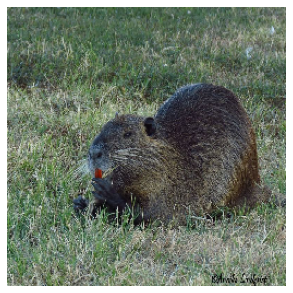

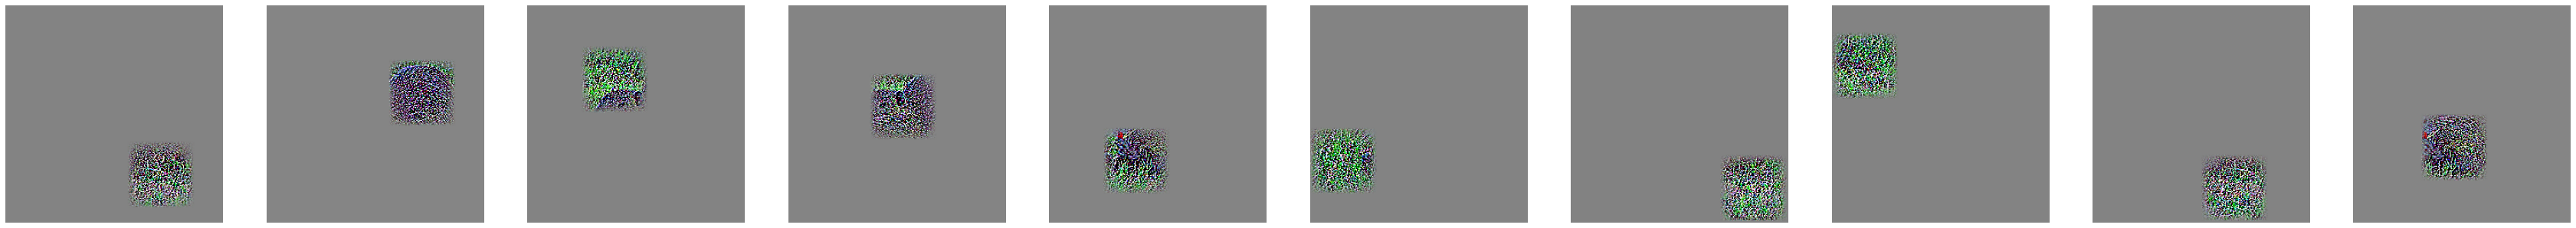

In [90]:
#------------GUIDED BACKPROPAGATION---------------------------------------------
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 12))

wandb.init(project="Assignment 2")
wandb.run.name = "Guided BackPropagation"

#-----------Load an image
plt.imshow(load_image("inaturalist_12K/val/Mammalia/9e014930ee1bd2f4079320ec01ce8858.jpg", preprocess=False))
plt.axis("off");
plt.figure(figsize=(60, 60))
wandb.log({"Guided_BackProp": [wandb.Image(load_image("inaturalist_12K/val/Mammalia/9e014930ee1bd2f4079320ec01ce8858.jpg", preprocess=False), caption='Original')]})
plt.axis("off");
preprocessed_input = load_image("inaturalist_12K/val/Mammalia/9e014930ee1bd2f4079320ec01ce8858.jpg")

#-----------Guided Relu to remove negative gradients
ax = plt.subplot(1,10,i+1)
@tf.custom_gradient
def guidedRelu(x):
  def grad(dy):
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad


for i in range(10):
  
  wandb.init(project="Assignment 2")
  wandb.run.name = "Guided BackPropagation {}".format(i+1)  

  model = tf.keras.models.load_model(wandb.restore('model-best.h5', run_path="kodikarthik21/uncategorized/m5pfdn04").name) 
 # model.summary()
  gb_model = Model(
      inputs = [model.inputs],
      outputs = [model.get_layer('conv2d_4').output]  # Numbering from 0. Therefore
  )

  #-----------Selecting neurons at random from CONV5 Layer and doing Guided Backprop
  seed(i+6)
  rand2 = randint(outputs.shape[1])
  rand3 = randint(outputs.shape[2])
  rand4 = randint(outputs.shape[3])
  modif = np.zeros(outputs.shape)
  modif[0][rand2][rand3][rand4] = 1; # Array to be multiplied with output for guided backprop

  layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]
  for layer in layer_dict:
    if layer.activation == tf.keras.activations.relu:
      layer.activation = guidedRelu

  with tf.GradientTape() as tape:
    inputs = tf.cast(preprocessed_input, tf.float32)
    tape.watch(inputs)
    outputs = gb_model(inputs)*modif # To assign all outputs to zero and only this to one

  grads = tape.gradient(outputs,inputs)[0]
  plt.subplot(1,10,i+1)
  plt.imshow(np.flip(deprocess_image(np.array(grads)),-1))
  wandb.log({"Guided_BackProp": [wandb.Image(np.flip(deprocess_image(np.array(grads)),-1), caption=i+1)]})
  plt.axis("off");